# Exploratory Data Analysis
This notebook will explore the cleaned dataset from <a href="https://www.gunviolencearchive.org/mass-shooting">Gun Violence Archive</a>

In [218]:
# import packages
import pandas as pd
import numpy as np
import pickle
import datetime

# visulaztion packages
import matplotlib.pyplot as plt
import seaborn as sns

In [219]:
# import pickled data
df = pd.read_pickle("./data/df")

# preview
df.head()

,incident_id,incident_date,state,city_or_county,address,#_killed,#_injured
0,2478664,2022-12-11,Illinois,Chicago,5500 block of W School St,3,1
1,2478061,2022-12-09,Arizona,Phoenix,S 21st and W Burgess LN,1,3
2,2477622,2022-12-08,Michigan,Detroit,1114 Washington Blvd,0,4
3,2477404,2022-12-08,Louisiana,New Orleans,4242 Chef Menteur Hwy,0,4
4,2475554,2022-12-06,New York,Bronx,Daly Ave and E 180th St,0,4


## Summary Statistics

In [220]:
df.describe()

,incident_id,#_killed,#_injured
count,2.000000e+03,2000.000000,2000.000000
mean,2.033979e+06,0.976000,4.149500
std,2.654732e+05,1.389744,2.188274
min,1.535478e+06,0.000000,0.000000
25%,1.786823e+06,0.000000,3.000000
50%,2.050260e+06,1.000000,4.000000
75%,2.274785e+06,1.000000,5.000000
max,2.478664e+06,22.000000,29.000000


As expected, looks like `#_injured` is more common than `#_killed` by almost 4:1 ratio on average per mass shooting. **Standard deviation** of `#_killed` is pretty significantly smaller than `#_injured` suggesting it deosn't vary that much, in fact the 75th percentile is only 1. This tells us the **Max** of 22 is extremely rare. I wonder what the statistical likiehood of that event happening. Perhaps this is something I can explore.

## Exploratory Plots

### Histograms

In [221]:
# histogram function
def hist_func(df, col, title, xlabel):
    """
    Provide df and column xlabel and title 
    to produce histogram
    """
    sns.histplot(df[col], binwidth=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

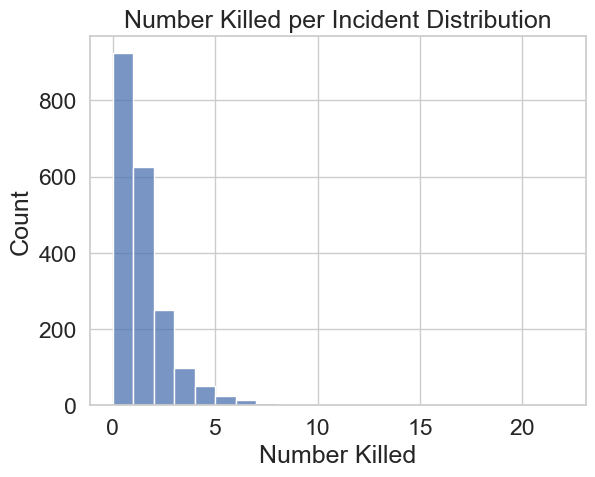

In [222]:
# histogram killed
hist_func(df, "#_killed", "Number Killed per Incident Distribution", "Number Killed")

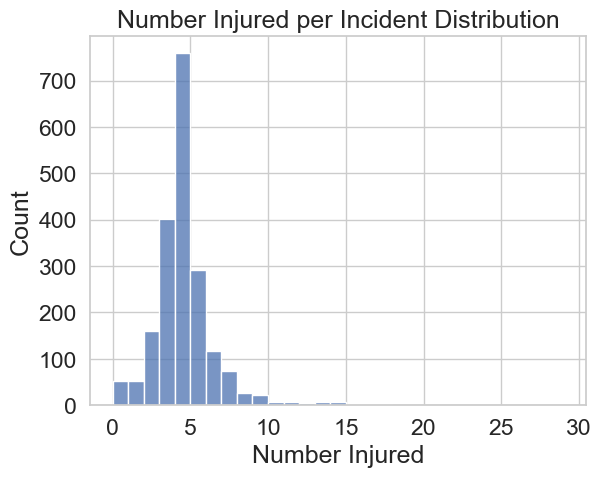

In [223]:
# histogram injured
hist_func(df, "#_injured", "Number Injured per Incident Distribution", "Number Injured")

We can see that `#_injured` is much more normal than `#_killed`, however there are still some outliers in `#_injured`.
<br>
`#_killed` is right-skewed.
<br>
4 is the most common amount for those injured.

### Boxplots

In [224]:
# melt to utilize catplot
df_melt = df.melt(
    id_vars=['incident_id', 'incident_date', 'state', 'city_or_county', 'address'])

# preview
df_melt.head()

,incident_id,incident_date,state,city_or_county,address,variable,value
0,2478664,2022-12-11,Illinois,Chicago,5500 block of W School St,#_killed,3
1,2478061,2022-12-09,Arizona,Phoenix,S 21st and W Burgess LN,#_killed,1
2,2477622,2022-12-08,Michigan,Detroit,1114 Washington Blvd,#_killed,0
3,2477404,2022-12-08,Louisiana,New Orleans,4242 Chef Menteur Hwy,#_killed,0
4,2475554,2022-12-06,New York,Bronx,Daly Ave and E 180th St,#_killed,0


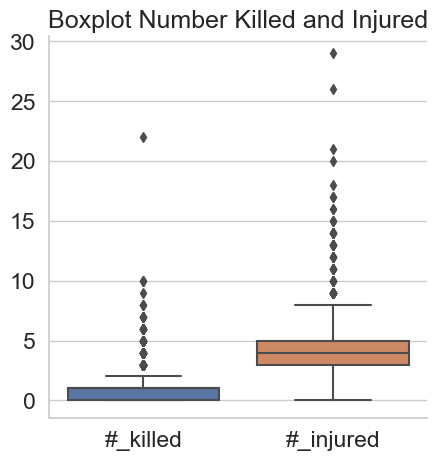

In [225]:
# boxplot
sns.catplot(data=df_melt,kind="box",
           x="variable", y="value")
plt.title("Boxplot Number Killed and Injured")
plt.ylabel("")
plt.xlabel("")
plt.show()

### Scatterplot
Let's take a look at the relationship of killed vs. injured

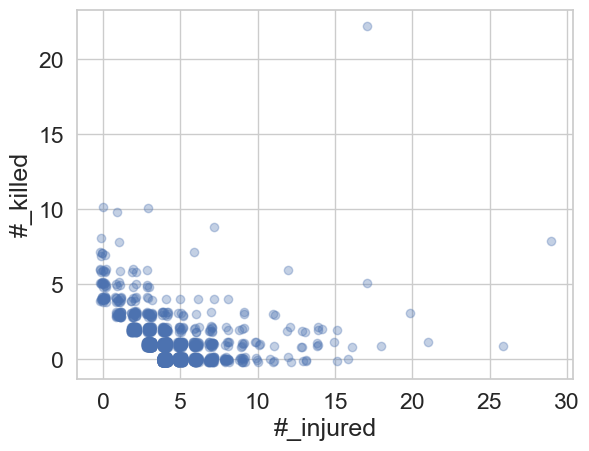

In [226]:
# scatterplot
sns.regplot(data=df,
            x="#_injured",
            y="#_killed", 
            fit_reg=False,
            x_jitter=0.2,
            y_jitter=0.2,
            scatter_kws = {'alpha' : 1/3})
plt.show()

Looks like there is a negative relationship between `#_injured` and `#_killed`.

### State Exploration
Let's look at which states have the most mass shootings.<br>
We will need to bring in some census data soon so that we can compare this in ratio as opposed to pure amount. Some states have higher population then others, therefore 

In [227]:
# first sum up each column
tot_injured = df["#_injured"].sum()
tot_killed = df["#_killed"].sum()

print("Number injured:", tot_injured)
print("Number killed:", tot_killed)
print("Ratio of killed to injured", round(tot_killed/tot_injured,2))

Number injured: 8299
Number killed: 1952
Ratio of killed to injured 0.24


In [228]:
# create groupby function
def groupby_one_col_sum(df,col_group,col_agg,sort=False):
    """
    Pass df, grouped column, sum column
    Index will be reset and values sorted default ascending = False
    """
    df = pd.DataFrame(df.groupby(col_group)[col_agg].sum()\
                     .sort_values(ascending=sort))
    df.reset_index(inplace=True)
    return df

In [229]:
# state killed
df_state_killed = groupby_one_col_sum(df,"state","#_killed")
# state injured
df_state_injured = groupby_one_col_sum(df,"state","#_injured")

In [230]:
#top 5
print(df_state_injured.head())
print("\n")
print(df_state_killed.head())

        state  #_injured
0    Illinois        963
1       Texas        584
2  California        559
3    New York        455
4     Florida        434


        state  #_killed
0       Texas       200
1  California       179
2    Illinois       153
3     Florida        84
4     Georgia        78


In [231]:
# function for bar plot
def bar_state(df, colx, coly, xlabel, title, figsize=(14,12), titlesize=20):
    """
    Plots bar chart grouped by state
    """
    sns.set_theme(context="notebook", 
                  style="whitegrid",
                 font_scale=1.5)
    plt.figure(figsize=figsize)
    sns.barplot(df,
                x=df[colx],
                y=df[coly],
                orient="h",
               palette="Blues")
    plt.xlabel(xlabel)
    plt.ylabel("")
    plt.title(title, fontsize=titlesize)
    plt.show()

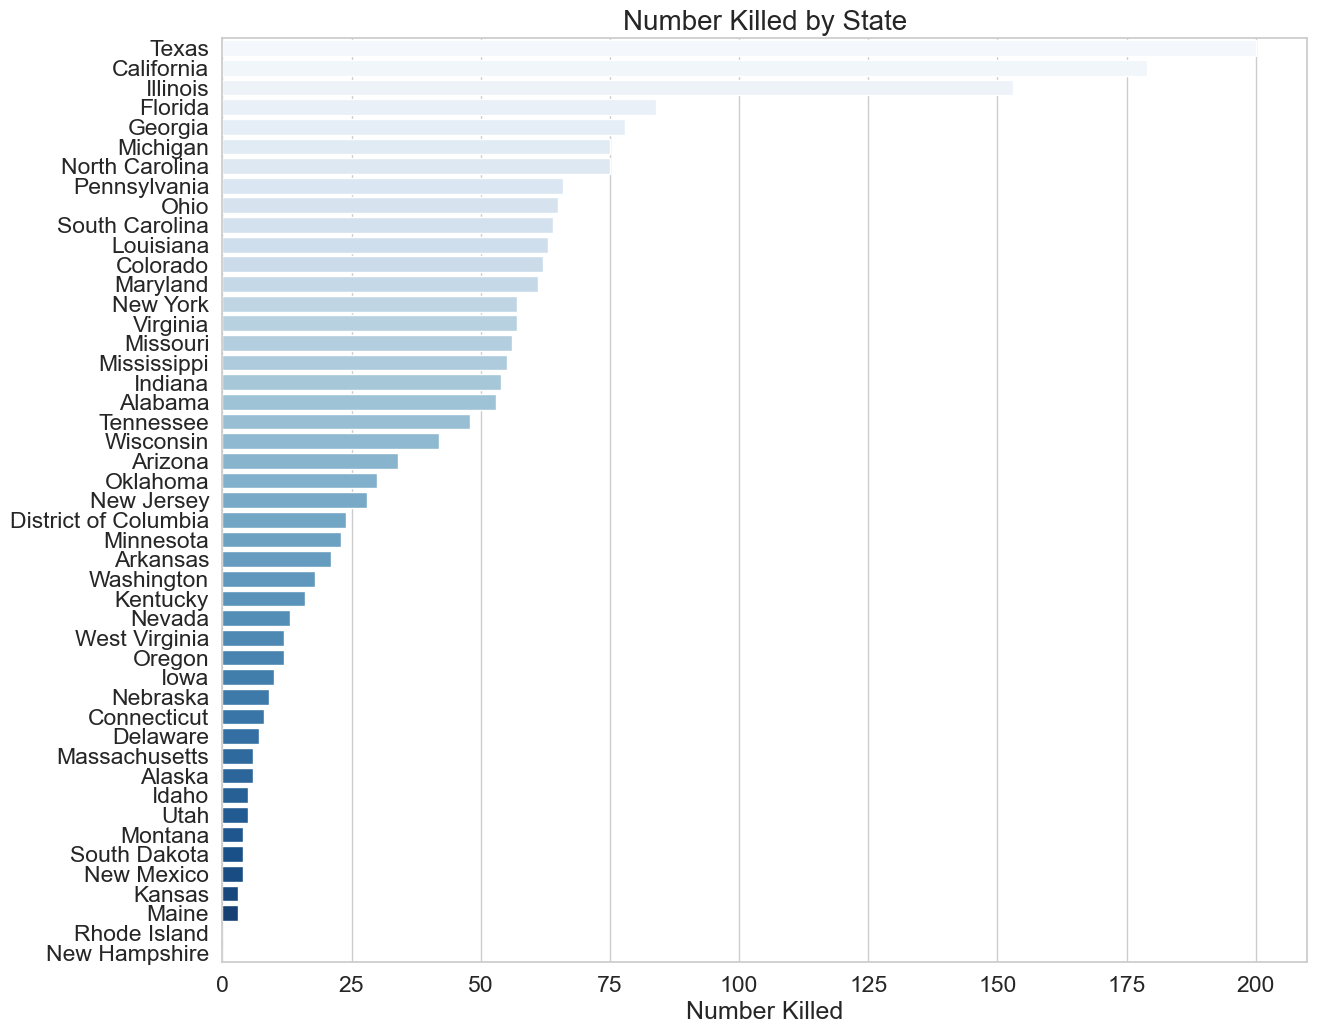

In [232]:
bar_state(df_state_killed, "#_killed","state","Number Killed", "Number Killed by State")

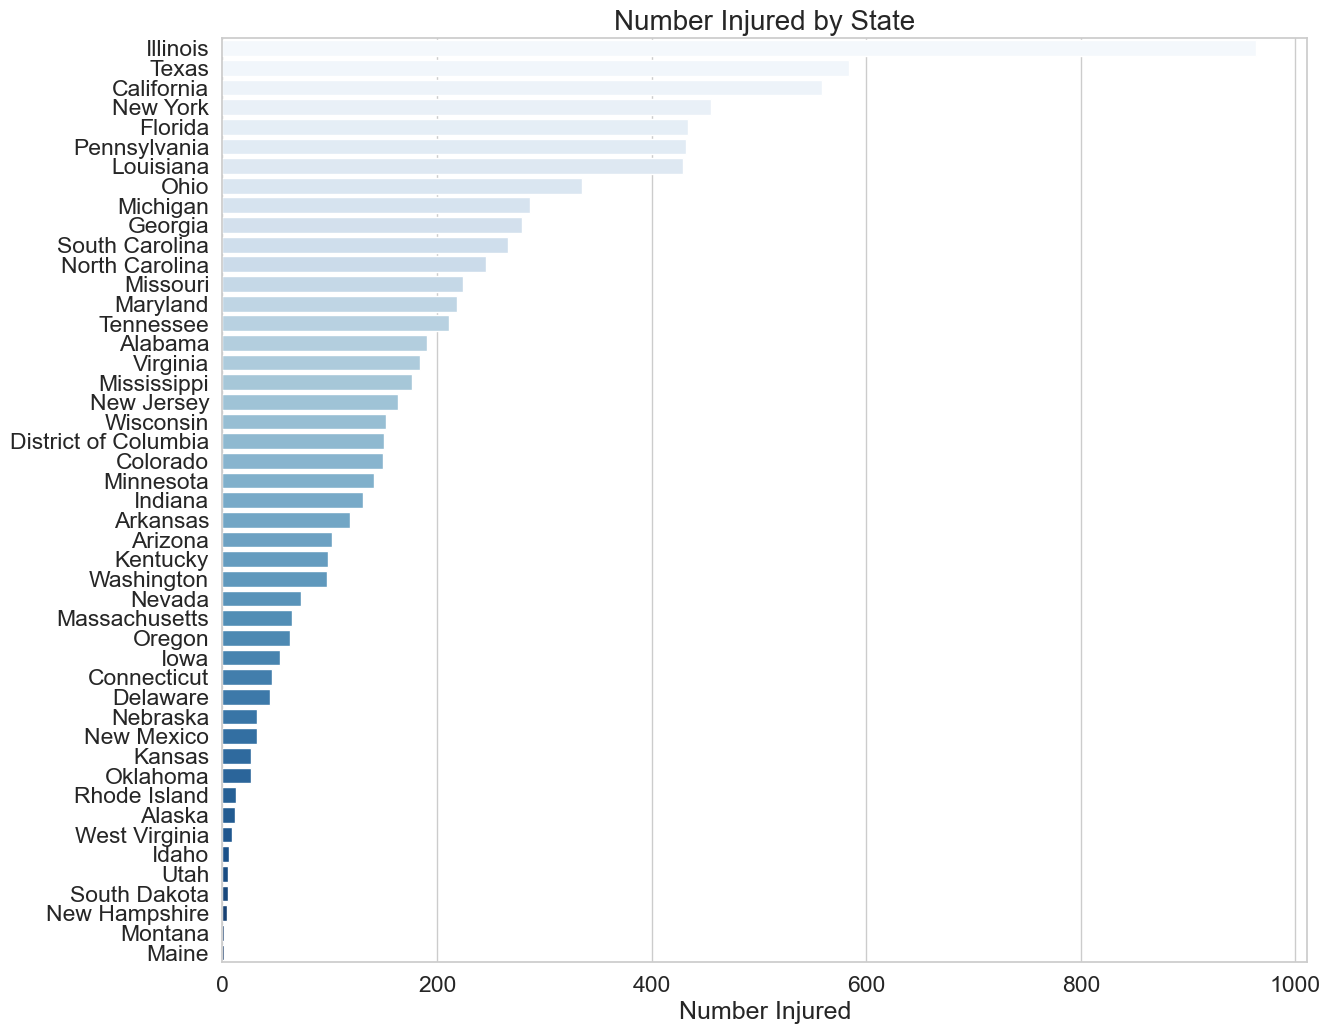

In [233]:
bar_state(df_state_injured, "#_injured", "state","Number Injured", "Number Injured by State")

Well what if we normalize the states to compare by `#_injured` and `#_killed` by ratio of events happening within each state.<br>
So, per event, how many are injured and how many are killed.

In [234]:
# groupby state with killed and injured summed along with a count colum
df_state_grouped_count = df.groupby("state")\
.agg({"#_injured":"sum","#_killed":"sum","incident_id":"count"})\
.sort_values(by=["incident_id","#_injured","#_killed"],\
             ascending=False).reset_index()

# preview result
df_state_grouped_count.head()

,state,#_injured,#_killed,incident_id
0,Illinois,963,153,214
1,Texas,584,200,146
2,California,559,179,145
3,New York,455,57,104
4,Pennsylvania,432,66,104


In [235]:
# rename incident_id col
df_state_grouped_count.rename(columns={"incident_id":"count"}, inplace=True)

In [236]:
# create total injured/killed column per state
df_state_grouped_count["total_injured_killed"] = \
df_state_grouped_count["#_killed"] + df_state_grouped_count["#_injured"]

Now need to create ratio columns

In [243]:
# function to create ratio column
def ratio_func(df,col1,col2,new_col):
    """
    This function will create a new column that is a ratio of col1 / col2
    """
    df[new_col] = round(df[col1] / df[col2],2)

In [244]:
# killed by incident
ratio_func(df_state_grouped_count,"#_killed","count","killed_by_incident" )
# injured by incident
ratio_func(df_state_grouped_count, "#_injured","count","injured_by_incident")
# injured and killed by incident
ratio_func(df_state_grouped_count, "total_injured_killed","count","total_by_incident")

In [247]:
# preview results ratio columns
df_state_grouped_count.sort_values(by="killed_by_incident", ascending=False).head()

,state,#_injured,#_killed,count,total_injured_killed,killed_by_incident,injured_by_incident,total_by_incident
45,Montana,1,4,1,5,4.00,1.00,5.00
46,Maine,1,3,1,4,3.00,1.00,4.00
39,West Virginia,9,12,4,21,3.00,2.25,5.25
34,Oklahoma,27,30,11,57,2.73,2.45,5.18
42,Utah,5,5,2,10,2.50,2.50,5.00


I have to control by population otherwise these ratios do not make much sense.

This plot would be interesting as a map as well.<br>
Also compare top 5.

### Date exploration

What if we looked at date, creating a month and year column and then look at when the most mass shootings happened?

In [149]:
# create year, month, day
df["day"] = df["incident_date"].dt.day
df["month"] = df["incident_date"].dt.month
df["year"] = df["incident_date"].dt.year
df["dayofweek"] = df["incident_date"].dt.weekday
df["dayname"] = df["incident_date"].dt.day_name()

# preview
df.head()

,incident_id,incident_date,state,city_or_county,address,#_killed,#_injured,day,month,year,dayofweek,dayname
0,2478664,2022-12-11,Illinois,Chicago,5500 block of W School St,3,1,11,12,2022,6,Sunday
1,2478061,2022-12-09,Arizona,Phoenix,S 21st and W Burgess LN,1,3,9,12,2022,4,Friday
2,2477622,2022-12-08,Michigan,Detroit,1114 Washington Blvd,0,4,8,12,2022,3,Thursday
3,2477404,2022-12-08,Louisiana,New Orleans,4242 Chef Menteur Hwy,0,4,8,12,2022,3,Thursday
4,2475554,2022-12-06,New York,Bronx,Daly Ave and E 180th St,0,4,6,12,2022,1,Tuesday
